In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')


In [60]:
test_name = 'all_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
model_type = 'CNN'

datas = []
for i in ['train', 'evaluate_before_train', 'evaluate']:

    file = f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/{model_type}/{test_name}/{i}/loss_{loss}_{model}.csv'
    names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2']

    data = pd.read_csv(file,
                    names = names)
    
    datas.append(data)

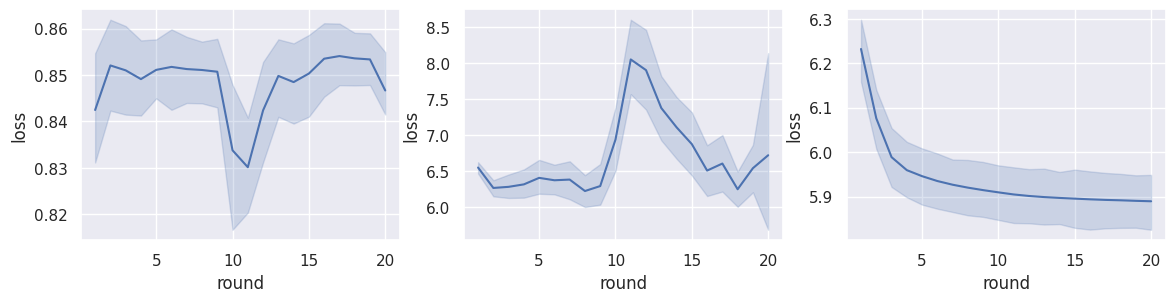

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.lineplot(datas[i], x = 'round', y = 'loss', ax = axs[i])#, hue='cid', alpha = 0.3)

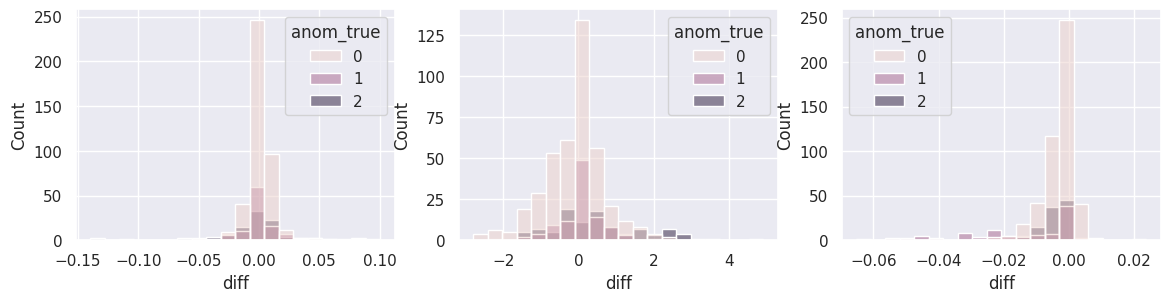

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    datas[i]['anom_true'] = datas[i]['round'].apply(lambda x: 1 if x==3 or x==4 or x==5 else (2 if x==12 or x==10 or x==11 else 0))
    sns.histplot(x = datas[i]['diff'], hue = datas[i]['anom_true'], bins = 20, ax = axs[i])

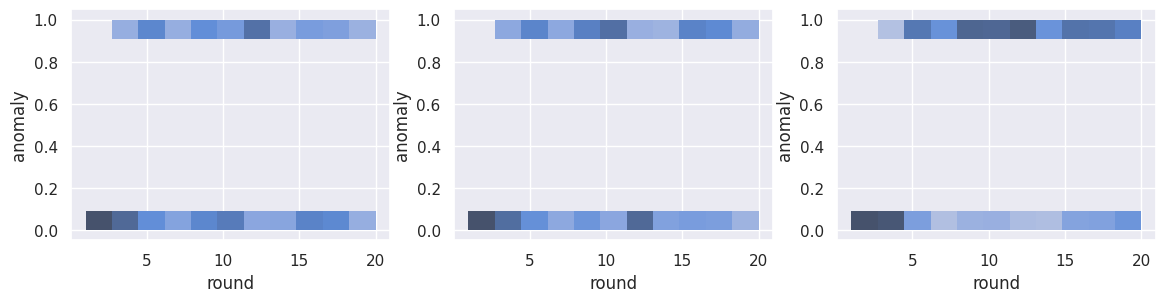

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

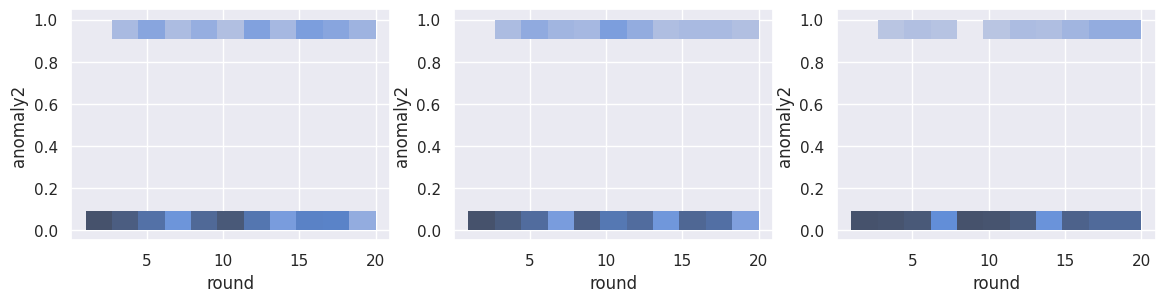

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i in range(3):
    sns.histplot(x = datas[i]['round'], y = datas[i]['anomaly2'], ax = axs[i])#, hue = data['anom_true'], bins = 20)

In [65]:
for i in range(3):

    data = datas[i]
    data['true_anomaly'] = data['round'].apply(lambda x: 1 if x>=9 else 0)

    data['anomaly12'] = data['anomaly'] + data['anomaly2'] 
    data['anomaly12'] = data['anomaly12'].apply(lambda x: 1 if x==2 else x)

    print('Anomaly1 ',f1_score(data['anomaly'], data['true_anomaly']),
        precision_score(data['anomaly'], data['true_anomaly']),
        recall_score(data['anomaly'], data['true_anomaly']),
        accuracy_score(data['anomaly'], data['true_anomaly']))

    print('Anomaly2 ',f1_score(data['anomaly2'], data['true_anomaly']),
        precision_score(data['anomaly2'], data['true_anomaly']),
        recall_score(data['anomaly2'], data['true_anomaly']),
        accuracy_score(data['anomaly2'], data['true_anomaly']))
    
    print('Anomaly12 ',f1_score(data['anomaly12'], data['true_anomaly']),
        precision_score(data['anomaly12'], data['true_anomaly']),
        recall_score(data['anomaly12'], data['true_anomaly']),
        accuracy_score(data['anomaly12'], data['true_anomaly']))
    
    print('-----------')



Anomaly1  0.5519591141396933 0.4682080924855491 0.6721991701244814 0.5744336569579288
Anomaly2  0.3891213389121339 0.26878612716763006 0.7045454545454546 0.5275080906148867
Anomaly12  0.6309148264984227 0.5780346820809249 0.6944444444444444 0.6213592233009708
-----------
Anomaly1  0.598705501618123 0.5346820809248555 0.6801470588235294 0.598705501618123
Anomaly2  0.29082774049217003 0.18786127167630057 0.6435643564356436 0.48705501618122976
Anomaly12  0.6236220472440945 0.5722543352601156 0.6851211072664359 0.6132686084142395
-----------
Anomaly1  0.7484811664641555 0.7549019607843137 0.7421686746987952 0.6955882352941176
Anomaly2  0.2226980728051392 0.12745098039215685 0.8813559322033898 0.4661764705882353
Anomaly12  0.7748815165876777 0.8014705882352942 0.75 0.7205882352941176
-----------


In [66]:
#DESCENTRALIZED
# Anomaly1  0.5519591141396933 0.4682080924855491 0.6721991701244814 0.5744336569579288
# Anomaly2  0.3891213389121339 0.26878612716763006 0.7045454545454546 0.5275080906148867
# Anomaly12  0.6309148264984227 0.5780346820809249 0.6944444444444444 0.6213592233009708
# -----------
# Anomaly1  0.5792880258899676 0.5173410404624278 0.6580882352941176 0.5792880258899676
# Anomaly2  0.2945054945054945 0.1936416184971098 0.6146788990825688 0.48058252427184467
# Anomaly12  0.6122448979591837 0.5635838150289018 0.6701030927835051 0.6003236245954693
# -----------
# Anomaly1  0.6382393397524071 0.5686274509803921 0.7272727272727273 0.6132352941176471
# Anomaly2  0.27722772277227725 0.1715686274509804 0.7216494845360825 0.4632352941176471
# Anomaly12  0.6457765667574932 0.5808823529411765 0.7269938650306749 0.6176470588235294
# -----------


#Decoder (não é para haver diferença)
# Anomaly1  0.547008547008547 0.4624277456647399 0.6694560669456067 0.5711974110032363
# Anomaly2  0.3958333333333333 0.2745664739884393 0.7089552238805971 0.5307443365695793
# Anomaly12  0.6287519747235387 0.5751445086705202 0.6933797909407665 0.6197411003236246
# -----------
# Anomaly1  0.5886178861788617 0.523121387283237 0.6728624535315985 0.5906148867313916
# Anomaly2  0.2806236080178174 0.18208092485549132 0.6116504854368932 0.4773462783171521
# Anomaly12  0.611023622047244 0.5606936416184971 0.671280276816609 0.6003236245954693
# -----------
# Anomaly1  0.603085553997195 0.5269607843137255 0.7049180327868853 0.5838235294117647
# Anomaly2  0.2505050505050505 0.15196078431372548 0.7126436781609196 0.45441176470588235
# Anomaly12  0.611111111111111 0.5392156862745098 0.7051282051282052 0.5882352941176471
# -----------

In [67]:
#evaluate - wo PCA All
#Anomaly1  0.7466216216216216 0.8125 0.690625 0.7242647058823529
#Anomaly2  0.08304498269896195 0.04411764705882353 0.7058823529411765 0.5128676470588235
#Anomaly12  0.7504187604690116 0.8235294117647058 0.6892307692307692 0.7261029411764706

#running again:
#Anomaly1  0.7952380952380952 0.8186274509803921 0.7731481481481481 0.7470588235294118
#Anomaly2  0.13513513513513514 0.07352941176470588 0.8333333333333334 0.43529411764705883
#Anomaly12  0.8112543962485346 0.8480392156862745 0.7775280898876404 0.763235294117647

## running again:
# Anomaly1  0.7484811664641555 0.7549019607843137 0.7421686746987952 0.6955882352941176
# Anomaly2  0.2226980728051392 0.12745098039215685 0.8813559322033898 0.4661764705882353
# Anomaly12  0.7748815165876777 0.8014705882352942 0.75 0.7205882352941176

# train- wo Decoder
#Anomaly1  0.547008547008547 0.4624277456647399 0.6694560669456067 0.5711974110032363
#Anomaly2  0.4024896265560166 0.28034682080924855 0.7132352941176471 0.5339805825242718
#Anomaly12  0.6330708661417322 0.5809248554913294 0.6955017301038062 0.6229773462783171

#evaluate - wo PCA Encoder
#Anomaly1  0.6337448559670782 0.5661764705882353 0.719626168224299 0.6073529411764705
#Anomaly2  0.27218934911242604 0.16911764705882354 0.696969696969697 0.4573529411764706
#Anomaly12  0.645945945945946 0.5857843137254902 0.7198795180722891 0.6147058823529412


In [68]:
#evaluate - PCA2 All
#Anomaly1  0.6947040498442366 0.6861538461538461 0.7034700315457413 0.6716917922948074
#Anomaly2  0.1758241758241758 0.09846153846153846 0.8205128205128205 0.49748743718592964
#Anomaly12  0.7127496159754224 0.7138461538461538 0.7116564417177914 0.6867671691792295

#evaluate before train- PCA2 Decoder
#Anomaly1  0.5945072697899838 0.5317919075144508 0.673992673992674 0.5938511326860841
#Anomaly2  0.29074889867841414 0.1907514450867052 0.6111111111111112 0.47896440129449835
#Anomaly12  0.6151419558359622 0.5635838150289018 0.6770833333333334 0.6051779935275081

In [69]:
#evaluate - PCA3 All
#Anomaly1  0.7166454891994918 0.6911764705882353 0.7440633245382586 0.6720588235294118
#Anomaly2  0.25157232704402516 0.14705882352941177 0.8695652173913043 0.475
#Anomaly12  0.7338308457711443 0.7230392156862745 0.7449494949494949 0.6852941176470588

In [70]:
#evaluate - PCA4 All
#Anomaly1  0.7300380228136881 0.7058823529411765 0.7559055118110236 0.6867647058823529
#Anomaly2  0.18454935622317598 0.1053921568627451 0.7413793103448276 0.4411764705882353
#Anomaly12  0.7390761548064918 0.7254901960784313 0.7531806615776081 0.6926470588235294

In [71]:
#evaluate - PCA8 All
#Anomaly1  0.7688564476885644 0.7745098039215687 0.7632850241545893 0.7205882352941176
#Anomaly2  0.21397379912663755 0.12009803921568628 0.98 0.47058823529411764
#Anomaly12  0.7792521109770807 0.7916666666666666 0.7672209026128266 0.7308823529411764

In [72]:
34*20

680

In [73]:
#verificar tamanho dos experimentos
#verificar começo das anomalias